# Assign T cell annotations

To assemble our annotations, we'll read our clustered T cell data and assign our expert annotations to those clusters. We'll then inspect the annotations in our UMAP projections, and output final labels for these cells.

For T cells, we have multiple groups of cells to label. We clustered all T cells, then subset cell types for additional resolution. So, we'll load these sets, remove the subsets from the rest of the T cells, assign identities based on clusters in each, and finally concatenate all of the cell barcodes.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

### Helper function

These function makes it easy to pull csv and h5ad files stored in HISE as pandas DataFrames

In [2]:
def read_csv_uuid(csv_uuid):
    csv_path = '/home/jupyter/cache/{u}'.format(u = csv_uuid)
    if not os.path.isdir(csv_path):
        hise_res = hisepy.reader.cache_files([csv_uuid])
    csv_filename = os.listdir(csv_path)[0]
    csv_file = '{p}/{f}'.format(p = csv_path, f = csv_filename)
    df = pd.read_csv(csv_file, index_col = 0)
    return df

In [3]:
def read_obs_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file, backed = 'r')
    obs = adata.obs.copy()
    return obs

## Read subclustering results from HISE

In [4]:
cell_class = 't-cells'

In [5]:
h5ad_uuid = 'd6ebc576-34ea-4394-a569-e35e16f20253'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [6]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [7]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [8]:
adata = sc.read_h5ad(h5ad_file)

In [9]:
adata.shape

(1191327, 1487)

## Read iterative results from hise

In [10]:
iter_uuids = {
    't-cd4-naive':     '70651e60-282b-4ed0-96f6-414547297232',
    't-cd8-mait':      '66f8dee3-2b84-45fc-a4c8-706795eacdfb',
    't-cd8-cm':        '6c1dff43-ddc5-437b-8e3d-dd5a32553b16',
    't-cd8-em':        'b671c53a-2698-41c1-a886-9ab939306716',
    'treg':            '5aee2daa-ad60-4ef5-9db9-efbd737d6232',
    't-cd8-naive':     '5ae29893-5a77-4081-86d1-523713a237e6',
    't-proliferating': '90a71622-5713-47f7-82e8-18e164ca9454',
    't-gd':            'b8175f61-2430-4395-8d0d-5c6e3b2f36c7',
    't-isg-high':      'd33ef147-59db-4fb6-950c-1dd8af242d4f',
    't-other':         'bda4fe2f-1d8a-4ec5-9ce7-6bee1a158d7b'
}

In [11]:
iter_obs = {}
for cell_type, uuid in iter_uuids.items():
    obs = read_obs_uuid(uuid)
    iter_obs[cell_type] = obs

## Drop gdT cells from non-gdT data

For gdT cells subclustering, we included some cells that initially clustered with MAIT, CD8 CM, and CD8 EM cells. Here, we'll identify our gdT cells, then drop the cells that were labeled with gdTs from the other subclustering results so we don't have duplicates.

In [12]:
gdt_bc = iter_obs["t-gd"]['barcodes'].tolist()
len(gdt_bc)

54170

In [13]:
drop_set = ['t-cd8-mait', 't-cd8-cm', 't-cd8-em']

In [14]:
for cell_type in drop_set:
    obs = iter_obs[cell_type]
    n_start = obs.shape[0]
    keep_bc = [not x for x in obs['barcodes'].isin(gdt_bc)]
    obs = obs[keep_bc]
    n_end = obs.shape[0]
    print('{c}; N Start: {s}; N End: {e}'.format(c = cell_type, s = str(n_start), e=str(n_end)))
    
    iter_obs[cell_type] = obs

t-cd8-mait; N Start: 50823; N End: 48027
t-cd8-cm; N Start: 43289; N End: 37568
t-cd8-em; N Start: 118291; N End: 105726


## Assign labels to cell barcodes

Now, we'll join cell type labels from our cluster annotations to our cell barcode-level observations.

In [15]:
anno_uuids = {
    't-cd4-naive':     '06ab755a-d8c8-4c4a-b85f-15526ca25f71',
    'treg':            '1abe8449-22e2-4d3d-b439-e0d3f3c60044',
    't-other':         '669ea022-a745-4681-83e2-1709f3dace34',
    't-cd8-naive':     '996a205c-3878-4300-8411-4f1b1cffa781',
    't-cd8-mait':          'afd0124f-d88e-46ba-9cea-80753be5eb5a',
    't-gd':            'bddcee0c-64f5-491a-bd27-57000d62dfe0',
    't-proliferating': 'e1b5f2da-af31-44e6-bbe4-3d5680f3aa5c',
    't-cd8-em':        'e5c5039f-d463-4d1a-854b-309ae69b1259',
    't-cd8-cm':        'e9075995-9ef4-431c-9dd7-a1a5e200765f',
    't-isg-high':      'eb19cc44-b6f8-4780-af1c-cf266b05e7dc'
}

In [16]:
iter_anno = {}
for cell_type,uuid in anno_uuids.items():
    iter_anno[cell_type] = read_csv_uuid(uuid)

In [17]:
iter_bc_anno = {}
for cell_type,sub_obs in iter_obs.items():
    sub_anno = iter_anno[cell_type]
    join_col = sub_anno.columns[0]
    sub_anno[join_col] = sub_anno[join_col].astype(str).astype('category')
    sub_obs = sub_obs.merge(sub_anno, on = join_col, how = 'left')
    sub_obs = sub_obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
    iter_bc_anno[cell_type] = sub_obs

## Assemble all labels

In [18]:
all_anno = pd.concat(iter_bc_anno)

In [19]:
all_anno.shape

(1191327, 4)

In [20]:
adata.shape

(1191327, 1487)

## Add to AnnData to preview assignments

In [21]:
obs = adata.obs
obs = obs.reset_index(drop = True)
obs = obs.merge(all_anno, on = 'barcodes', how = 'left')
obs = obs.set_index('barcodes', drop = True)

In [22]:
adata.obs = obs

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


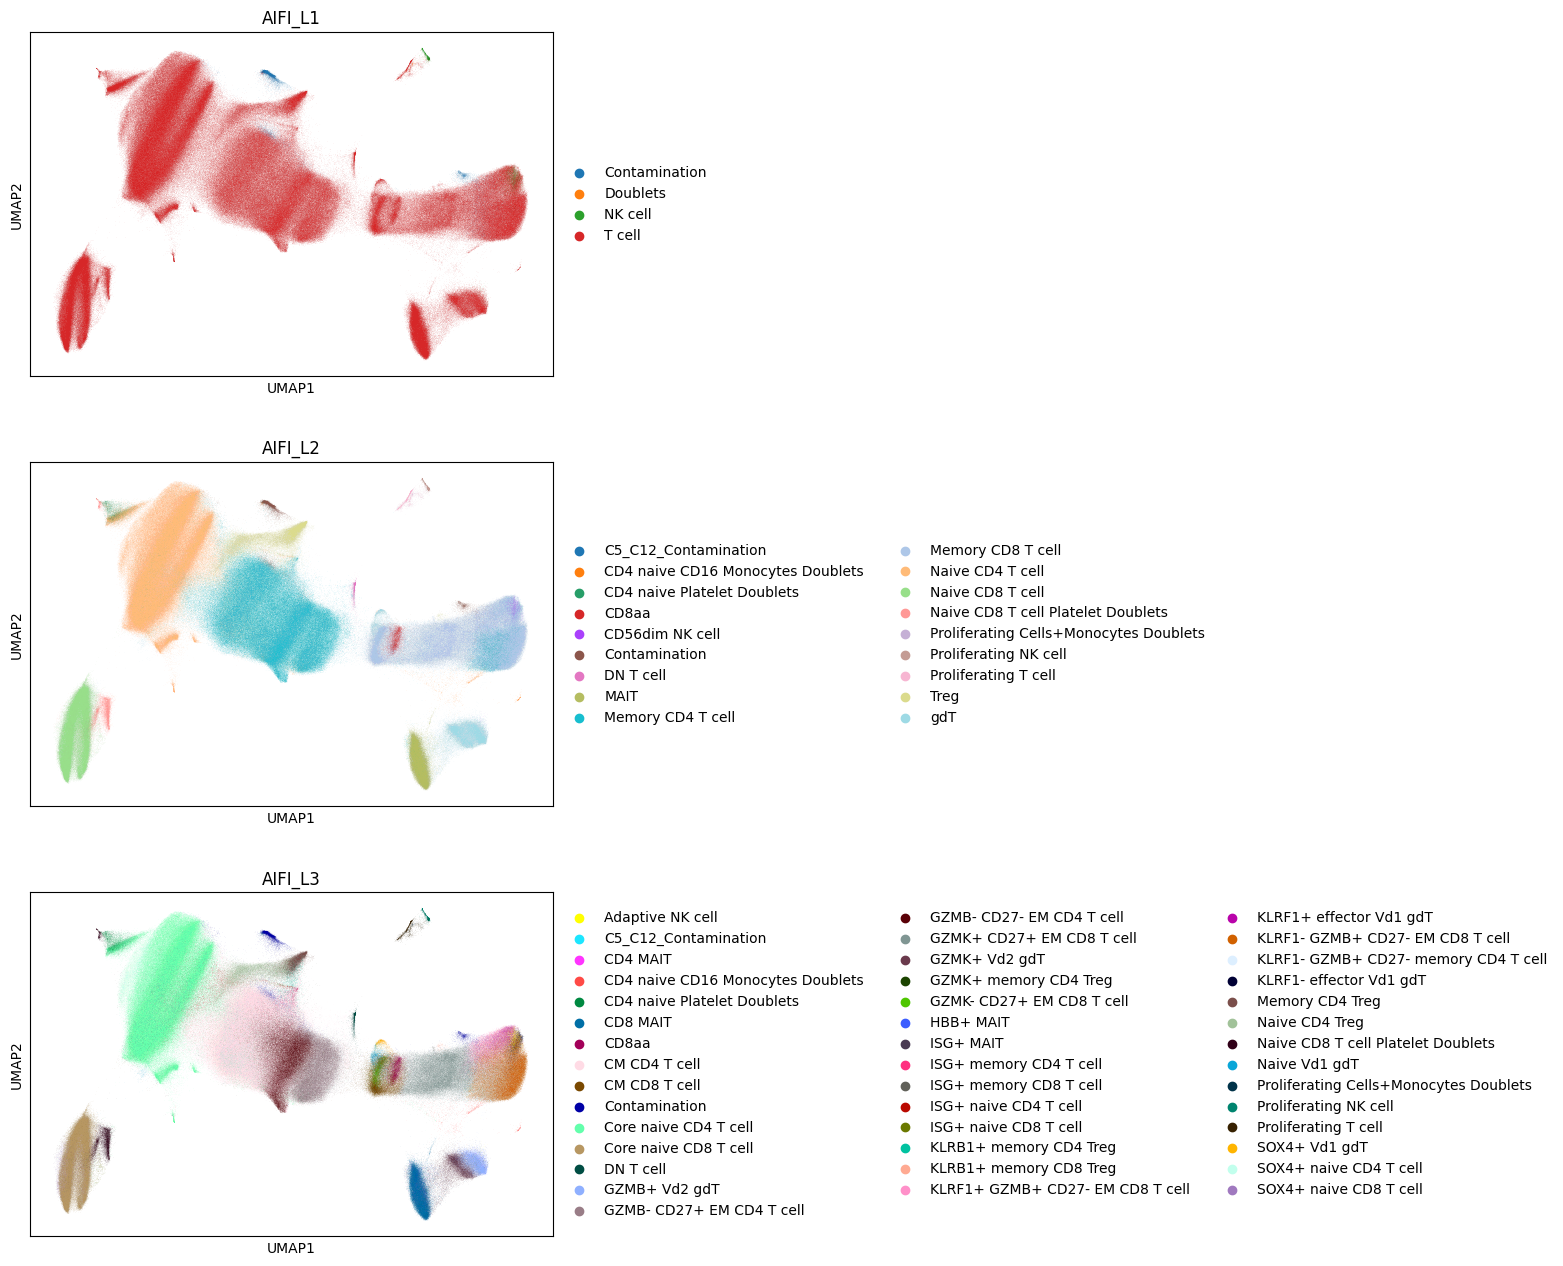

In [23]:
sc.pl.umap(adata, color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'], ncols = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


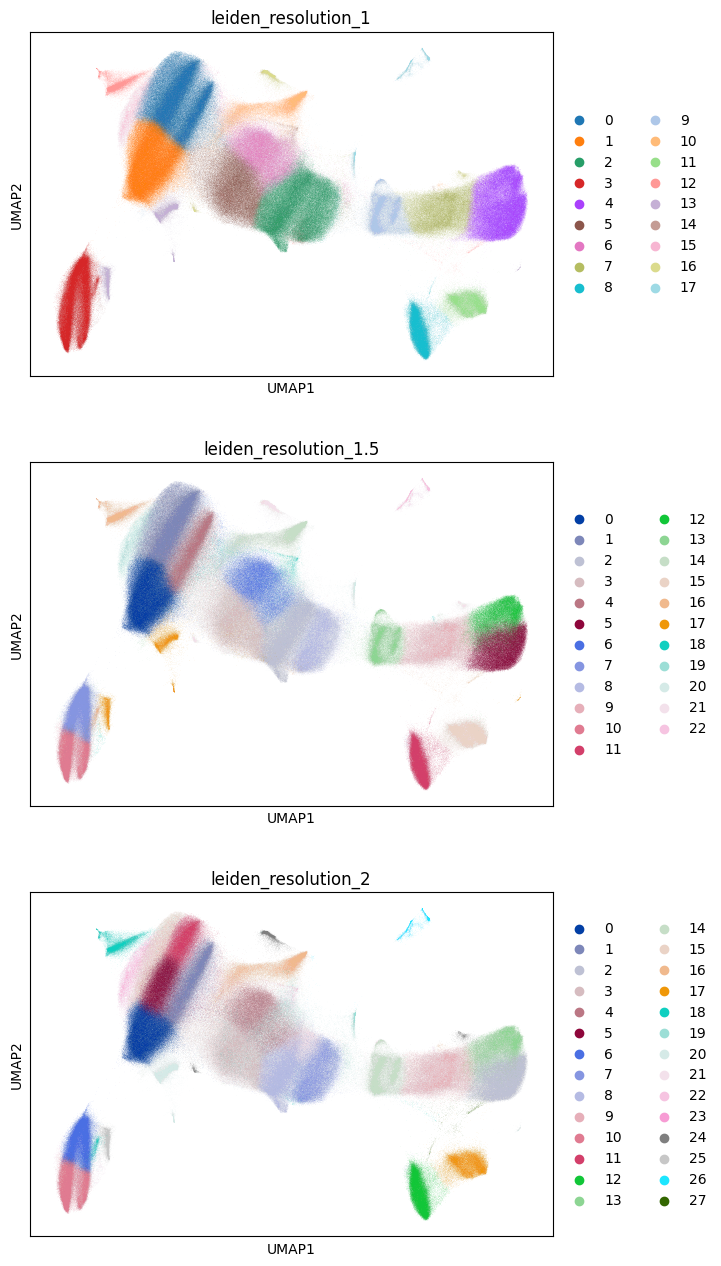

In [24]:
sc.pl.umap(adata, 
           color = ['leiden_resolution_1',
                    'leiden_resolution_1.5',
                    'leiden_resolution_2'],
           ncols = 1)

## Output final annotations

In [25]:
obs = adata.obs
obs = obs.reset_index(drop = False)

In [26]:
umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [27]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,AIFI_L1,AIFI_L2,AIFI_L3,umap_1,umap_2
0,cf71f47048b611ea8957bafe6d70929e,B001,weathered_pernicious_polliwog,cf71f47048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1081,115,9307,...,4.032258,13,8,11,12,T cell,MAIT,CD8 MAIT,6.384859,-4.117041
1,cf71f54248b611ea8957bafe6d70929e,B001,untidy_emulsive_hamadryad,cf71f54248b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1923,178,22729,...,2.731737,2,12,16,18,T cell,Naive CD4 T cell,Core naive CD4 T cell,-4.634521,3.974752
2,cf71fb7848b611ea8957bafe6d70929e,B001,long_weakminded_roebuck,cf71fb7848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1118,77,12990,...,2.071006,1,5,6,4,T cell,Memory CD4 T cell,CM CD4 T cell,-0.504904,1.140365
3,cf7216a848b611ea8957bafe6d70929e,B001,bimetallic_returnable_pony,cf7216a848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1836,249,21279,...,4.098091,11,2,8,7,T cell,Memory CD4 T cell,GZMB- CD27+ EM CD4 T cell,2.885731,-0.563941
4,cf72178448b611ea8957bafe6d70929e,B001,newsworthy_copacetic_halicore,cf72178448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,928,60,9412,...,2.130682,0,1,0,0,T cell,Naive CD4 T cell,SOX4+ naive CD4 T cell,-4.179520,0.825014


In [28]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [29]:
obs_out_csv = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)

In [30]:
obs_out_parquet = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [31]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [32]:
label_out_csv = '{p}/ref_pbmc_{c}_barcode_labels_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [33]:
label_out_parquet = '{p}/ref_pbmc_{c}_barcode_labels_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Upload annotations to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [34]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'T cell barcode annotations {d}'.format(d = date.today())

In [35]:
iter_h5ad_uuids = list(iter_uuids.values())
iter_anno_uuids = list(anno_uuids.values())

In [36]:
in_files = [h5ad_uuid] + iter_h5ad_uuids + iter_anno_uuids

In [37]:
in_files

['d6ebc576-34ea-4394-a569-e35e16f20253',
 '70651e60-282b-4ed0-96f6-414547297232',
 '66f8dee3-2b84-45fc-a4c8-706795eacdfb',
 '6c1dff43-ddc5-437b-8e3d-dd5a32553b16',
 'b671c53a-2698-41c1-a886-9ab939306716',
 '5aee2daa-ad60-4ef5-9db9-efbd737d6232',
 '5ae29893-5a77-4081-86d1-523713a237e6',
 '90a71622-5713-47f7-82e8-18e164ca9454',
 'b8175f61-2430-4395-8d0d-5c6e3b2f36c7',
 'd33ef147-59db-4fb6-950c-1dd8af242d4f',
 'bda4fe2f-1d8a-4ec5-9ce7-6bee1a158d7b',
 '06ab755a-d8c8-4c4a-b85f-15526ca25f71',
 '1abe8449-22e2-4d3d-b439-e0d3f3c60044',
 '669ea022-a745-4681-83e2-1709f3dace34',
 '996a205c-3878-4300-8411-4f1b1cffa781',
 'afd0124f-d88e-46ba-9cea-80753be5eb5a',
 'bddcee0c-64f5-491a-bd27-57000d62dfe0',
 'e1b5f2da-af31-44e6-bbe4-3d5680f3aa5c',
 'e5c5039f-d463-4d1a-854b-309ae69b1259',
 'e9075995-9ef4-431c-9dd7-a1a5e200765f',
 'eb19cc44-b6f8-4780-af1c-cf266b05e7dc']

We should have 10 h5ad's and 10 annotations

In [38]:
len(in_files)

21

In [39]:
out_files = [obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [40]:
out_files

['output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.csv',
 'output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.parquet',
 'output/ref_pbmc_t-cells_barcode_labels_2024-03-04.csv',
 'output/ref_pbmc_t-cells_barcode_labels_2024-03-04.parquet']

In [41]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.csv
output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.parquet
output/ref_pbmc_t-cells_barcode_labels_2024-03-04.csv
output/ref_pbmc_t-cells_barcode_labels_2024-03-04.parquet
you are trying to upload file_ids... ['output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.csv', 'output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.parquet', 'output/ref_pbmc_t-cells_barcode_labels_2024-03-04.csv', 'output/ref_pbmc_t-cells_barcode_labels_2024-03-04.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'bb39c8ac-f6cc-4a2b-8f07-4264b7d333d5',
 'files': ['output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.csv',
  'output/ref_pbmc_t-cells_labeled_meta_umap_2024-03-04.parquet',
  'output/ref_pbmc_t-cells_barcode_labels_2024-03-04.csv',
  'output/ref_pbmc_t-cells_barcode_labels_2024-03-04.parquet']}

In [42]:
import session_info
session_info.show()